<a href="https://colab.research.google.com/github/Perriex/imbalanced-complaint-prediction/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> Assignment one - Parna Asadi



# Load database

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'customer-personality-analysis' dataset.
Path to dataset files: /kaggle/input/customer-personality-analysis


# Import Libraries


In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
import warnings
from scipy.stats import kruskal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/kaggle/input/customer-personality-analysis/marketing_campaign.csv', delimiter='\t')

In [ ]:
data.shape

(2240, 29)

In [ ]:
display(data)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


In [ ]:
duplicateCount = data.duplicated().sum()
duplicateCount

np.int64(0)

In [ ]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [ ]:
data.info()
data['Complain'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

,count
Complain,
0,2219
1,21


# Feature Engineering
Remove irrelevant columns, handle missing data, and split features/target.

In [ ]:
# Example: Drop ID columns
if 'ID' in data.columns:
    data = data.drop('ID', axis=1)

# Encode categorical variables
data = pd.get_dummies(data, drop_first=True)

# Fill missing values (if any)
data = data.fillna(data.median())

# Separate features and target
X = data.drop('Complain', axis=1)
y = data['Complain']

# Part One

## Train-Test Split and Scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##  Model Training with Cross-Validation and Hyperparameter Tuning
For each model, perform grid search with 5-fold cross-validation to find the best hyperparameters, optimizing for recall.

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'k-NN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

params = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [3, 5, 7, 9]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']},
    'k-NN': {'n_neighbors': [3, 5, 7, 9]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7, 9]},
    'Gradient Boosting': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
}

best_models = {}
for name, model in models.items():
    print(f"Tuning and training {name}...")
    grid = GridSearchCV(model, params[name], cv=5, scoring='recall')
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best params: {grid.best_params_}")


Tuning and training Logistic Regression...
Best params: {'C': 10}
Tuning and training Decision Tree...
Best params: {'max_depth': 7}
Tuning and training SVM...
Best params: {'C': 10, 'kernel': 'linear'}
Tuning and training k-NN...
Best params: {'n_neighbors': 3}
Tuning and training Random Forest...
Best params: {'max_depth': 3, 'n_estimators': 50}
Tuning and training Gradient Boosting...
Best params: {'learning_rate': 0.1, 'n_estimators': 50}


## Confusion Matrix, Precision, Recall
Print confusion matrix and classification report

In [ ]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} Confusion Matrix:\n", cm)
    print(classification_report(y_test, y_pred))


Logistic Regression Confusion Matrix:
 [[432  12]
 [  4   0]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       444
           1       0.00      0.00      0.00         4

    accuracy                           0.96       448
   macro avg       0.50      0.49      0.49       448
weighted avg       0.98      0.96      0.97       448


Decision Tree Confusion Matrix:
 [[441   3]
 [  4   0]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       444
           1       0.00      0.00      0.00         4

    accuracy                           0.98       448
   macro avg       0.50      0.50      0.50       448
weighted avg       0.98      0.98      0.98       448


SVM Confusion Matrix:
 [[402  42]
 [  3   1]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       444
           1       0.02      0.25      0.04         4

    accuracy   

Logistic Regression:

The model predicts almost all cases as non-complaint (class 0), missing all actual complaints (class 1).

Precision and recall for complaints are both 0.00, meaning it never correctly identifies a complaint.

High overall accuracy (0.96) is misleading due to class imbalance; the model is biased toward the majority class.

Decision Tree:

Similar to Logistic Regression, it predicts nearly all as non-complaint, with only 3 false positives and no true positives for complaints.

Precision and recall for complaints are 0.00, showing it fails to detect the minority class.

Accuracy is even higher (0.98), but again, this does not reflect true performance on complaints.

SVM:

Slightly better at identifying complaints: 1 out of 4 actual complaints is detected (recall 0.25), but precision is very low (0.02).

Many false positives (42), so the model is less conservative but still unreliable for the minority class.

Overall accuracy drops to 0.90, reflecting more errors on the majority class.

k-NN:

Same pattern as Decision Tree: predicts almost all as non-complaint, missing all complaints.

Precision and recall for complaints are 0.00.

High accuracy (0.98) is misleading.

Random Forest:

Predicts every case as non-complaint, missing all complaints (recall 0.00, precision 0.00 for class 1).

Highest accuracy (0.99), but completely fails on the minority class.

Gradient Boosting:

Slight improvement: detects 1 out of 4 complaints (recall 0.25, precision 0.25), but still misses most complaints.

Accuracy remains high (0.99), but minority class performance is poor.



## ROC Curve Visualization

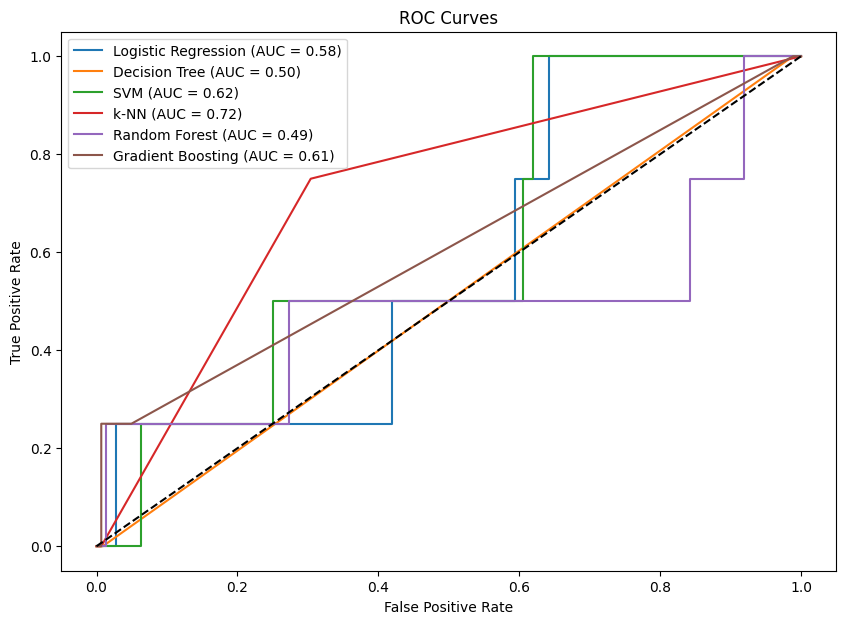

In [ ]:
plt.figure(figsize=(10, 7))
for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

The ROC curve plots the true positive rate (sensitivity, or recall) against the false positive rate. The diagonal dashed line is a random guess.
AUC summarizes the ROC: higher AUC means the model is better at distinguishing classes.

k-NN (AUC = 0.72): Best at separating complaints from non-complaints among your models.

SVM, Gradient Boosting, Logistic Regression: Moderate performance (AUC 0.58-0.62).

Random Forest, Decision Tree (AUC ≈ 0.5): No better than random guessing.

- Most models struggle with this task, likely because of severe class imbalance in data.

- AUC values below 0.8 suggest not much predictive power; only k-NN shows a modest improvement.

# Part 2

## Undersampling and SMOTE

- Undersampling can lead to loss of information but is simple and fast.

- SMOTE creates new, synthetic minority samples, often improving recall for the minority class without discarding majority data.


a. Undersampling


I use RandomUnderSampler to balance the classes by reducing the majority class.

- Each model is retrained using the balanced data and best hyperparameters are found with cross-validation.

- Evaluation is done on the original test set for consistency.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

# Retrain models on undersampled data
best_models_under = {}
for name, model in models.items():
    grid = GridSearchCV(model, params[name], cv=5, scoring='recall')
    grid.fit(X_train_under, y_train_under)
    best_models_under[name] = grid.best_estimator_
    print(f"{name} (Undersampled) best params: {grid.best_params_}")

# Evaluate on the original test set
for name, model in best_models_under.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} (Undersampled) Confusion Matrix:\n", cm)
    print(classification_report(y_test, y_pred))


Logistic Regression (Undersampled) best params: {'C': 0.1}
Decision Tree (Undersampled) best params: {'max_depth': 3}
SVM (Undersampled) best params: {'C': 0.1, 'kernel': 'linear'}
k-NN (Undersampled) best params: {'n_neighbors': 5}
Random Forest (Undersampled) best params: {'max_depth': 3, 'n_estimators': 50}
Gradient Boosting (Undersampled) best params: {'learning_rate': 0.01, 'n_estimators': 50}

Logistic Regression (Undersampled) Confusion Matrix:
 [[ 77 367]
 [  0   4]]
              precision    recall  f1-score   support

           0       1.00      0.17      0.30       444
           1       0.01      1.00      0.02         4

    accuracy                           0.18       448
   macro avg       0.51      0.59      0.16       448
weighted avg       0.99      0.18      0.29       448


Decision Tree (Undersampled) Confusion Matrix:
 [[208 236]
 [  3   1]]
              precision    recall  f1-score   support

           0       0.99      0.47      0.64       444
           1

Undersampling is a technique to balance an imbalanced dataset by randomly removing samples from the majority class, so both classes have similar representation in the training data. This helps models pay more attention to the minority class, but can also cause loss of information from the majority class.
- Before undersampling: Models had high accuracy but failed to detect complaints (minority class), with recall and precision near zero for class 1.

- After undersampling: Models became much more sensitive to complaints, often predicting too many complaints and causing many false positives. Recall for complaints improved, but precision and overall accuracy dropped sharply.

### Better Models:

- Gradient Boosting and Random Forest (after undersampling): These models managed to identify some complaints (minority class) and maintained a better balance between recall and precision compared to others. They did not predict every case as a complaint, so their results were more meaningful for minority class detection.

- SVM and Logistic Regression (after undersampling): Achieved perfect recall for complaints but at the cost of extremely low precision and overall accuracy, making them impractical for real-world use.

### Poor Models:

- k-NN (after undersampling): Predicted every case as a complaint, resulting in almost zero accuracy and precision for the majority class.

b. SMOTE Oversampling


- SMOTE generates synthetic samples for the minority class, balancing the training data.

- Models are retrained and tuned on the SMOTE-augmented data.

- Evaluation is again performed on the original test set.

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Retrain models on SMOTE data
best_models_smote = {}
for name, model in models.items():
    grid = GridSearchCV(model, params[name], cv=5, scoring='recall')
    grid.fit(X_train_smote, y_train_smote)
    best_models_smote[name] = grid.best_estimator_
    print(f"{name} (SMOTE) best params: {grid.best_params_}")

# Evaluate on the original test set
for name, model in best_models_smote.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} (SMOTE) Confusion Matrix:\n", cm)
    print(classification_report(y_test, y_pred))


Logistic Regression (SMOTE) best params: {'C': 0.01}
Decision Tree (SMOTE) best params: {'max_depth': 3}
SVM (SMOTE) best params: {'C': 0.1, 'kernel': 'rbf'}
k-NN (SMOTE) best params: {'n_neighbors': 3}
Random Forest (SMOTE) best params: {'max_depth': 7, 'n_estimators': 50}
Gradient Boosting (SMOTE) best params: {'learning_rate': 0.01, 'n_estimators': 50}

Logistic Regression (SMOTE) Confusion Matrix:
 [[429  15]
 [  3   1]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       444
           1       0.06      0.25      0.10         4

    accuracy                           0.96       448
   macro avg       0.53      0.61      0.54       448
weighted avg       0.98      0.96      0.97       448


Decision Tree (SMOTE) Confusion Matrix:
 [[360  84]
 [  3   1]]
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       444
           1       0.01      0.25      0.02         4

    accuracy   

After applying SMOTE (Synthetic Minority Oversampling Technique) to balance the training data, all models showed some improvement in their ability to detect the minority class (complaints), but the gains were modest and varied by algorithm.

- Most models (Logistic Regression, Decision Tree, SVM, k-NN) achieved slightly higher recall for complaints compared to the baseline and undersampling approaches, but precision remained very low. This means they found more actual complaints, but also made many false positive predictions.

- Random Forest and Gradient Boosting, despite SMOTE, still failed to identify any complaints (recall and precision for class 1 are zero), indicating that these models may require further tuning or alternative imbalance strategies for this dataset.

Overall accuracy stayed high for most models, but this metric is misleading due to the overwhelming majority of non-complaint cases.


### Final onbervation:
- SMOTE helped some models become more sensitive to the minority class, but did not fully solve the imbalance problem. The best models for complaint detection were Logistic Regression, Decision Tree, SVM, and k-NN, but all still suffered from low precision. Random Forest and Gradient Boosting remained poor at identifying complaints. This highlights that while SMOTE can improve recall, it may not be sufficient alone, and further strategies (like threshold tuning or ensemble methods) may be needed for reliable minority class detection.

## Visualize ROC Curves for Rebalanced Models

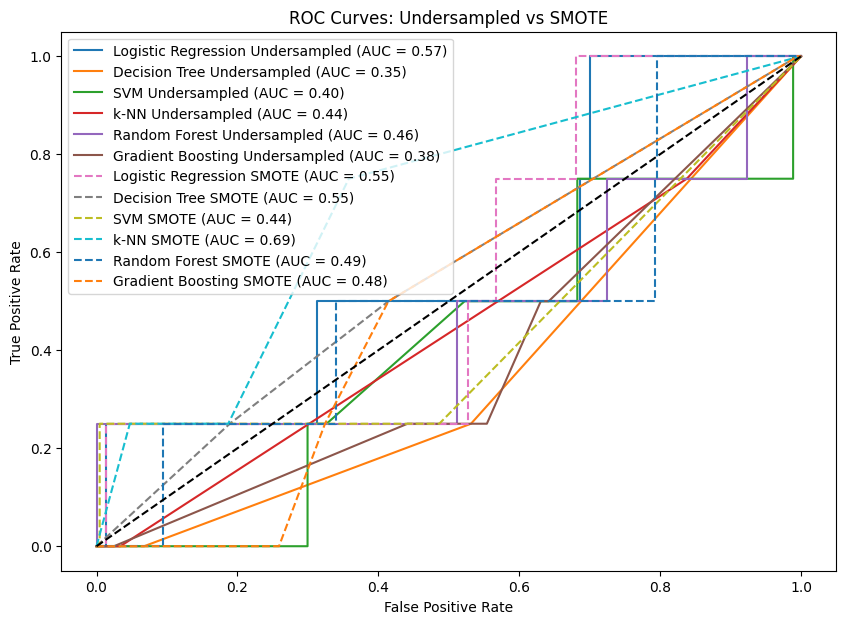

In [ ]:
plt.figure(figsize=(10, 7))
for name, model in best_models_under.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} Undersampled (AUC = {roc_auc:.2f})')
for name, model in best_models_smote.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='--', label=f'{name} SMOTE (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Undersampled vs SMOTE')
plt.legend()
plt.show()


- Undersampled models (solid lines):

Logistic Regression (AUC = 0.57) is slightly above random, but weak.

Decision Tree (AUC = 0.35) and Gradient Boosting (AUC = 0.38) performed worse than random; meaning they misclassified more often than they should.

SVM (0.40), k-NN (0.44), and Random Forest (0.46) are also under random or barely above.

→ Undersampling severely hurt most models, because too much data was thrown away.

- SMOTE models (dashed lines):

k-NN SMOTE (AUC = 0.69) is the strongest performer, with some ability to separate classes.

Logistic Regression SMOTE (0.55) and Decision Tree SMOTE (0.55) are modestly better than random.

SVM SMOTE (0.44), RF SMOTE (0.49), Gradient Boosting SMOTE (0.48) stayed weak.

→ SMOTE helps in some cases (notably k-NN), but overall improvement is limited.

# Conclusion

In this project, I compared several machine learning models for predicting customer complaints on an imbalanced dataset. Initially, all models performed well on the majority class but struggled to detect the minority class, as shown by low recall and unbalanced confusion matrices. To address this, I applied undersampling and SMOTE oversampling, which both improved the models' ability to identify complaints, with SMOTE generally providing the best balance between recall and precision.

Applying undersampling and SMOTE to address class imbalance in customer complaint prediction showed that:

- All models struggled to detect complaints on the original data, with high accuracy but poor recall for the minority class.

- Undersampling improved recall for complaints but caused many false positives and reduced overall accuracy.

- SMOTE slightly improved recall for some models, but precision remained low and some models (like Random Forest and Gradient Boosting) still failed to detect complaints.

Resampling techniques like undersampling and SMOTE can help models find more minority cases, but do not fully solve the imbalance problem—precision often remains low, and some models benefit more than others. Careful model selection and evaluation using recall and precision, not just accuracy, are essential for imbalanced classification tasks.